### 머신러닝 - 은행 마케팅 캠페인 



#### 1. 데이터 불러오기

In [ ]:
# 구글 드라이브 연결

from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
#사용할 라이브러리 불러오기 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
%matplotlib inline

#데이터 파일 읽어오기, 구분자 ;
bank_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/bank.csv', delimiter=';')

#10개 데이터 출력
bank_df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


In [4]:
#데이터 정보를 확인 한다(누락값 여부, type)
print(bank_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB
None


###-> 누락값이 없음을 확인하였다.

## **은행 마케팅 캠페인 데이터**
###입력변수(은행 고객 데이터)
1 - age: 나이 (numeric)

2 - job : 직업 (categorical: 'admin', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')

3 - marital : 결혼 여부 (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: 채무불이행여부 (categorical: 'no','yes','unknown')

6- balance: 연간 평균 잔고[EUR] (numeric)

7 - housing: 주택융자 유무 (catgorical: 'no','yes','unknown')

8 - loan: 개인융자 유무 (categorical: 'no','yes','unknown')

####<현재 캠페인의 마지막 컨택 관련>
9 - contact: 의사소통 수단 (categorical: 'cellular','telephone')

10 - day: 마지막 접촉일의 일

11 - month: 마지막 접촉일의 월 (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

12 - duration: 마지막 접촉 기간, 초단위 (numeric)

*실제 예측 모델을 사용하는 경우에는 버려야 한다. 벤치마크 목적으로만 포함시켜야 한다.

#### <다른 속성>
13 - campaign: 캠페인 동안 해당 고객 컨택 횟수 (numeric, includes last contact)

14 - pdays: 이전 캠페인에서 고객에게 마지막으로 연락한 후 경과한 일 수 (numeric; 999: 이전 캠페인에서 해당고객에게 연락하지 않음)

15 - previous: 이 캠페인 전 해당 고객에게 컨택한 횟수 (numeric)

16 - poutcome: 이전 캠페인의 결과 (categorical: 'failure','nonexistent','success')



###출력 변수
1. y: 정기예금 가입 여부



##2. 데이터 파악

###2-1. 기술통계량 확인

In [5]:
bank_df.y.value_counts()

no     4000
yes     521
Name: y, dtype: int64

-> 마케팅결과 데이터(y)에 불균형이 있음을 확인할 수 있다.

####각 변수의 통계량을 확인한다.

In [6]:
bank_df.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,4521.000000,4521,4521,4521,4521,4521.000000,4521,4521,4521,4521.000000,4521,4521.000000,4521.000000,4521.000000,4521.000000,4521,4521
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,management,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,969,2797,2306,4445,NaN,2559,3830,2896,NaN,1398,NaN,NaN,NaN,NaN,3705,4000
mean,41.170095,NaN,NaN,NaN,NaN,1422.657819,NaN,NaN,NaN,15.915284,NaN,263.961292,2.793630,39.766645,0.542579,NaN,NaN
std,10.576211,NaN,NaN,NaN,NaN,3009.638142,NaN,NaN,NaN,8.247667,NaN,259.856633,3.109807,100.121124,1.693562,NaN,NaN
min,19.000000,NaN,NaN,NaN,NaN,-3313.000000,NaN,NaN,NaN,1.000000,NaN,4.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,69.000000,NaN,NaN,NaN,9.000000,NaN,104.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,444.000000,NaN,NaN,NaN,16.000000,NaN,185.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,49.000000,NaN,NaN,NaN,NaN,1480.000000,NaN,NaN,NaN,21.000000,NaN,329.000000,3.000000,-1.000000,0.000000,NaN,NaN


###2-2. 데이터 시각화

- 마케팅 결과
- 채무불이행 유무
- 주택융자 유무
- 개인융자 유무
- 직업별 마케팅 결과
- 결혼 상태별 마케팅 결과
- 학력별 마케팅 결과


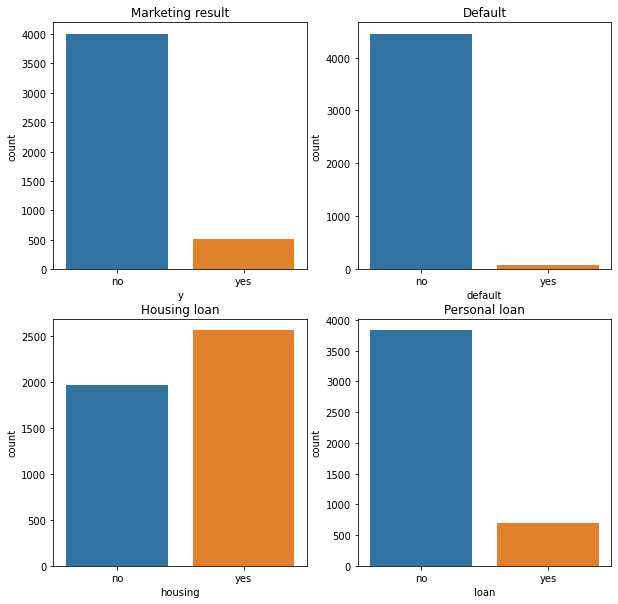

In [7]:

#4개의 그래프를 한 화면에 나타낸다.
#그래프 크기 설정

plt.figure(figsize=(10,10))

#마케팅 결과
plt.subplot(2,2,1)
plt.title('Marketing result')
sns.countplot(x='y', data=bank_df)

#채무불이행 유무
plt.subplot(2,2,2)
plt.title('Default')
sns.countplot(x='default', data=bank_df)

#주택융자 유무
plt.subplot(2,2,3)
plt.title('Housing loan')
sns.countplot(x='housing', data=bank_df)

#개인융자 유무
plt.subplot(2,2,4)
plt.title('Personal loan')
sns.countplot(x='loan', data=bank_df)

Text(0.5, 1.0, 'Marketing result according to job')

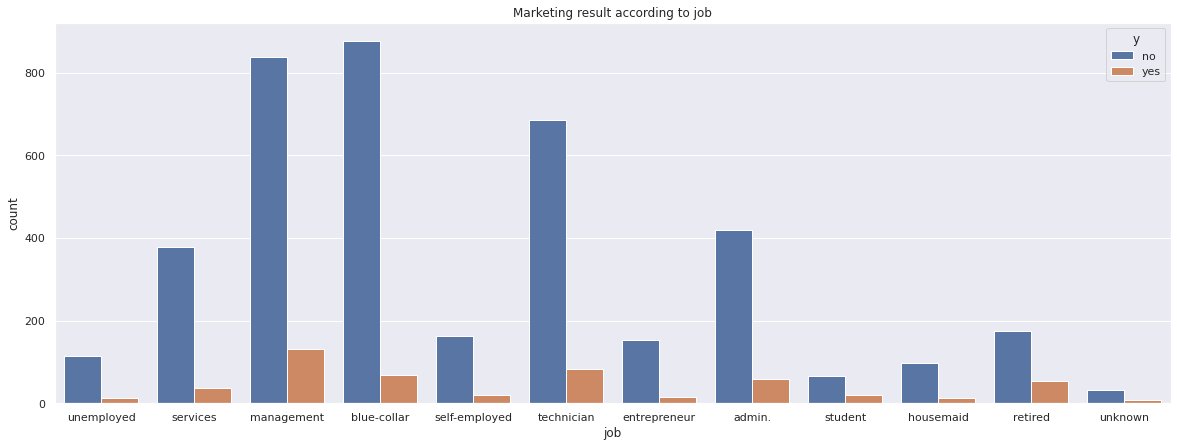

In [8]:
#직업별 마케팅 결과를 확인한다.

sns.set(rc={'figure.figsize':(20,7)})
sns.countplot(x=bank_df['job'], data=bank_df, hue=bank_df['y'])
plt.title('Marketing result according to job')


Text(0.5, 1.0, 'Marketing result according to martial')

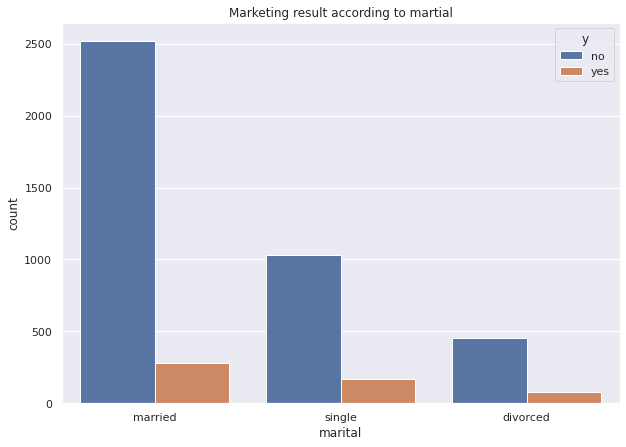

In [9]:
#결혼 상태 별 마케팅 결과를 확인한다.

sns.set(rc={'figure.figsize':(10,7)})
sns.countplot(x=bank_df['marital'], data=bank_df, hue=bank_df['y'])
plt.title('Marketing result according to martial')



Text(0.5, 1.0, 'Marketing result according to education')

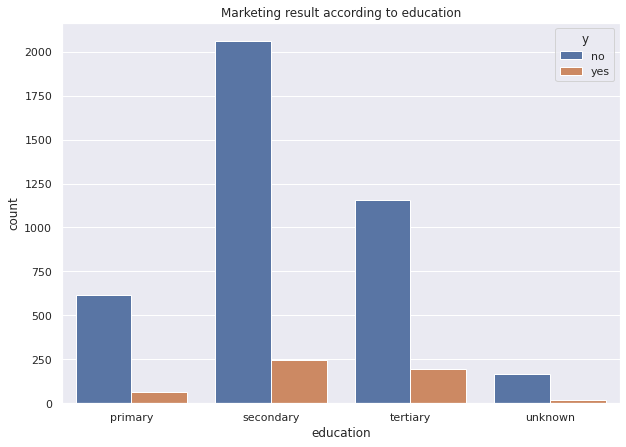

In [10]:
#학력별 마케팅 결과를 확인한다.

sns.set(rc={'figure.figsize':(10,7)})
sns.countplot(x=bank_df['education'], data=bank_df, hue=bank_df['y'])
plt.title('Marketing result according to education')


##3. 데이터 전처리

###데이터 정규화

In [11]:
#데이터 정규화 
from sklearn.preprocessing import StandardScaler

#데이터 중 숫자 데이터 열번호
idx_numeric=[0,5,9,11,12,13,14]

# StandardScaler객체 생성
scaler = StandardScaler()
#데이터 중 숫자 데이터에 대해 정규화를 시킨다.
bank_df[bank_df.columns[idx_numeric]] = scaler.fit_transform(bank_df[bank_df.columns[idx_numeric]])


In [12]:
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,-1.056270,unemployed,married,primary,no,0.121072,no,no,cellular,0.374052,oct,-0.711861,-0.576829,-0.407218,-0.320413,unknown,no
1,-0.772583,services,married,secondary,no,1.118644,yes,yes,cellular,-0.596026,may,-0.169194,-0.576829,2.989044,2.041734,failure,no
2,-0.583458,management,single,tertiary,no,-0.024144,yes,no,cellular,0.010273,apr,-0.303898,-0.576829,2.899143,0.270124,failure,no
3,-1.056270,management,married,tertiary,no,0.017726,yes,yes,unknown,-1.566105,jun,-0.250017,0.387967,-0.407218,-0.320413,unknown,no
4,1.686036,blue-collar,married,secondary,no,-0.472753,yes,no,unknown,-1.323585,may,-0.146102,-0.576829,-0.407218,-0.320413,unknown,no


###라벨 인코딩 사용

In [13]:
#라벨 인코딩을 사용하여 문자데이터 숫자로 변경한다.
from sklearn import preprocessing

def encode_features(dataDF):
    features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
    return dataDF

bank_pre = encode_features(bank_df)
bank_pre.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,-1.056270,10,1,0,0,0.121072,0,0,0,0.374052,10,-0.711861,-0.576829,-0.407218,-0.320413,3,0
1,-0.772583,7,1,1,0,1.118644,1,1,0,-0.596026,8,-0.169194,-0.576829,2.989044,2.041734,0,0
2,-0.583458,4,2,2,0,-0.024144,1,0,0,0.010273,0,-0.303898,-0.576829,2.899143,0.270124,0,0
3,-1.056270,4,1,2,0,0.017726,1,1,2,-1.566105,6,-0.250017,0.387967,-0.407218,-0.320413,3,0
4,1.686036,1,1,1,0,-0.472753,1,0,2,-1.323585,8,-0.146102,-0.576829,-0.407218,-0.320413,3,0


###전처리한 데이터로 변수간 상관계수 확인해보기
상관관계를 분석하기 위해 피어슨 계수를 사용하여 Heatmap으로 시각화

In [14]:
#피어슨 상관계수 구하기
#corr 함수 사용하여 pearson 방법을 사용하여 상관계수를 구한다.
cols = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign' ,'pdays', 'previous', 'poutcome', 'y'] 
corr = bank_pre[cols].corr(method = 'pearson')
corr

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
age,1.000000,-0.021500,-0.381485,-0.121613,-0.017885,0.083820,-0.193888,-0.011250,0.015161,-0.017853,-0.040714,-0.002367,-0.005148,-0.008894,-0.003511,-0.009320,0.045092
job,-0.021500,1.000000,0.069390,0.170160,0.008324,0.009797,-0.128353,-0.040245,-0.074068,0.012865,-0.096613,-0.006739,-0.002739,-0.022760,0.005029,0.013049,0.027401
marital,-0.381485,0.069390,1.000000,0.102714,-0.020745,0.024971,-0.029851,-0.045210,-0.068236,0.008794,-0.035855,0.006619,0.005915,0.017050,0.038028,-0.027716,0.015042
education,-0.121613,0.170160,0.102714,1.000000,-0.010534,0.057725,-0.087070,-0.054086,-0.110554,0.014926,-0.050086,-0.014878,-0.001723,0.012077,0.023983,-0.032135,0.042987
default,-0.017885,0.008324,-0.020745,-0.010534,1.000000,-0.070886,0.006881,0.063994,0.008448,-0.013261,0.014297,-0.011615,-0.012348,-0.026317,-0.026656,0.039032,0.001303
balance,0.083820,0.009797,0.024971,0.057725,-0.070886,1.000000,-0.050227,-0.071349,-0.009665,-0.008677,0.023113,-0.015950,-0.009976,0.009437,0.026196,-0.029268,0.017905
housing,-0.193888,-0.128353,-0.029851,-0.087070,0.006881,-0.050227,1.000000,0.018451,0.196454,-0.031291,0.266630,0.015740,-0.003574,0.116893,0.038621,-0.093093,-0.104683
loan,-0.011250,-0.040245,-0.045210,-0.054086,0.063994,-0.071349,0.018451,1.000000,-0.007319,-0.004879,0.016329,-0.004997,0.017120,-0.031086,-0.022115,0.027028,-0.070517
contact,0.015161,-0.074068,-0.068236,-0.110554,0.008448,-0.009665,0.196454,-0.007319,1.000000,-0.033807,0.370077,-0.011380,0.012278,-0.243223,-0.187232,0.267173,-0.133595
day,-0.017853,0.012865,0.008794,0.014926,-0.013261,-0.008677,-0.031291,-0.004879,-0.033807,1.000000,-0.014795,-0.024629,0.160706,-0.094352,-0.059114,0.073714,-0.011244


In [15]:
corr.values
column_names = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign' ,'pdays', 'previous', 'poutcome', 'y'] 

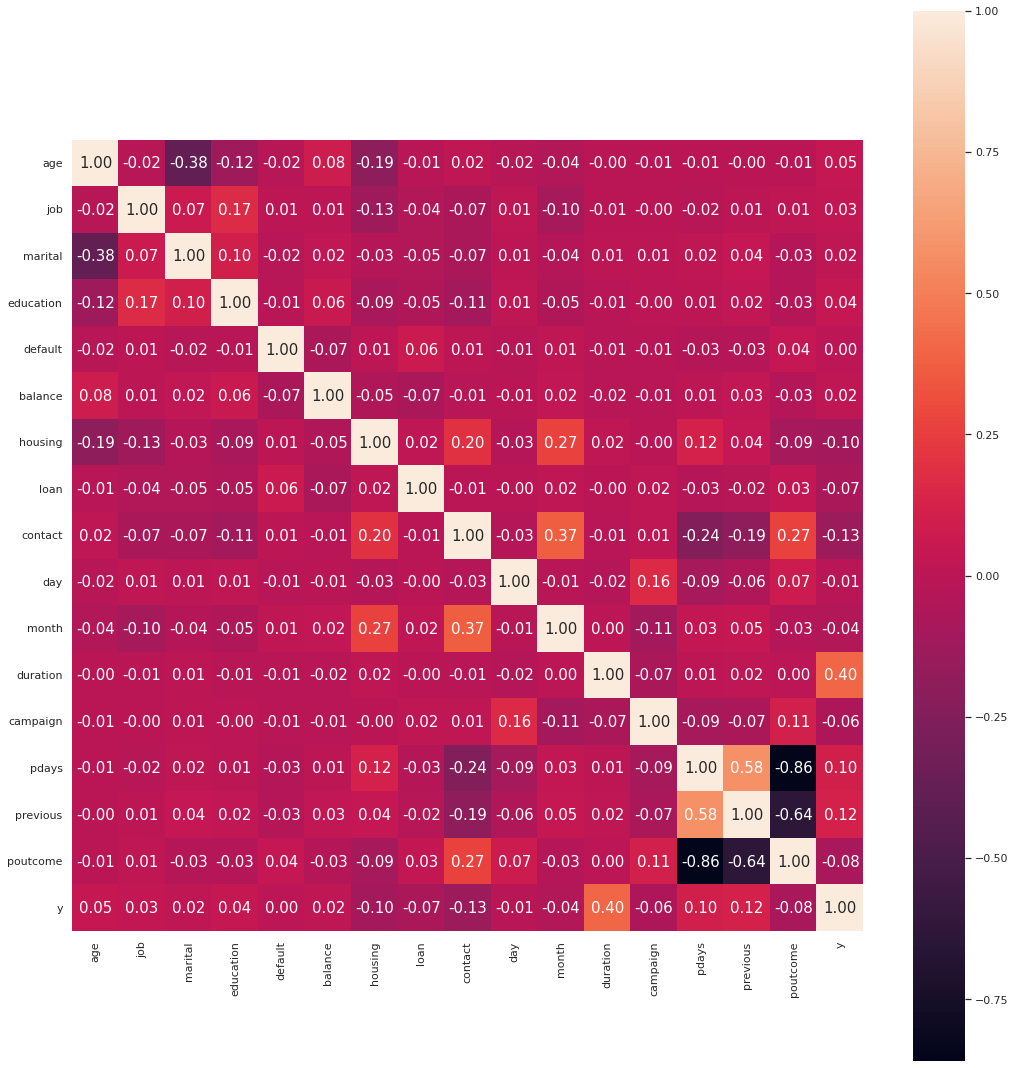

In [16]:
sns.set(rc = {'figure.figsize':(15,15)})  #그래프 사이즈
sns.set(font_scale=1)
hm = sns.heatmap(corr.values, #데이터
            cbar=True, #오른쪽 컬러 막대 출력 여부
            annot=True, #차트에 숫자를 보여줄 것인지 여부
            square=True, #차트를 정사각형으로 할 것인지
            fmt='.2f', #숫자의 출력 소수점 자리 개수 조절
            annot_kws={'size': 15}, #숫자 출력 시 숫자 크기 조절
            yticklabels=column_names, #y축에 컬럼명 출력
            xticklabels=column_names) #x축에 컬럼명 출력

plt.tight_layout()
plt.show()

-> pdays과 poutcome, previous와 poutcome에 음의상관관계가 있음을 확인할 수 있다.

-> 결과값인 y와 독립변수간에는 약한 상관관계가 있음을 확인할 수 있다.


###독립변수, 종속변수 나눠주기
- 종속변수: 마케팅 결과 'y'
- 독립변수: 종속변수 제외 모두

In [17]:
#독립변수, 종속 변수 나눠주기
y_bank_df = bank_pre['y']
X_bank_df= bank_pre.drop('y', axis=1)


In [18]:
#분석을 위해 데이터의 타입을 Int 로 변환한다.

X_bank_df = X_bank_df.astype('int')
y_bank_df = y_bank_df.astype('int')

###학습 데이터 셋: 80%, 테스트 데이터 셋: 20% 으로 나눠준다.




In [19]:
#train set : test set = 80 : 20

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_bank_df, y_bank_df, \
                                                  test_size=0.2, random_state=11)


In [21]:
#분류한 데이터셋을 분석하기 위해 int타입으로 변환

X_train = X_train.astype('int')
y_train = y_train.astype('int')
X_test = X_test.astype('int')
y_test = y_test.astype('int')

##4. 데이터 분석

###4.1 의사결정나무, 랜덤포레스트, 로지스틱 회귀를 사용하여 분석

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 의사결정나무, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression(max_iter=500)


# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train , y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train , y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train , y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도: 0.8552
RandomForestClassifier 정확도:0.8983
LogisticRegression 정확도: 0.9017


- max_iter는 Gradient Descent 방식을 반복해서 몇번 수행할 것인가를 나타냄
- 수렴하게 되면 max_iter 값을 늘려도 성능이 거의 달라지지 않는다.
- warning이 뜨지않는 max_iter값 입력(값이 작으면 warning이 뜬다. )


###4.2 k-fold 교차 검증

In [25]:
from sklearn.model_selection import KFold
#decision tree에 대해 5-fold
def exec_kfold(clf, folds=5):
    # 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한  리스트 객체 생성.
    kfold = KFold(n_splits=folds)
    scores = []
    
    # KFold 교차 검증 수행. 
    for iter_count , (train_index, test_index) in enumerate(kfold.split(X_bank_df)):
        # X_bank_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_bank_df.values[train_index], X_bank_df.values[test_index]
        y_train, y_test = y_bank_df.values[train_index], y_bank_df.values[test_index]
        
        # Classifier 학습, 예측, 정확도 계산 
        clf.fit(X_train, y_train) 
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))     
    
    # 5개 fold에서의 평균 정확도 계산. 
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score)) 
    
# exec_kfold 호출
exec_kfold(dt_clf , folds=5) 


교차 검증 0 정확도: 0.8564
교차 검증 1 정확도: 0.8496
교차 검증 2 정확도: 0.8662
교차 검증 3 정확도: 0.8650
교차 검증 4 정확도: 0.8606
평균 정확도: 0.8595


In [ ]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(dt_clf, X_bank_df , y_bank_df , cv=5, error_score='raise') #클래스가 불균형하게 섞여있을 때 트레인/테스트 분류: 층화

for iter_count,accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))

print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.8508
교차 검증 1 정확도: 0.8507
교차 검증 2 정확도: 0.8662
교차 검증 3 정확도: 0.8883
교차 검증 4 정확도: 0.8573
평균 정확도: 0.8626


-> cross_val_score를 사용해서 층화교차검증을 한 결과 k-fold로 분석했을 때 보다 평균 정확도가 0.8595에서 0.8626으로 상승하였다.

###4.3 GridSearchCV

모델 성능 향상 방법:GridSearchCV

In [26]:
from sklearn.model_selection import GridSearchCV


parameters = {'max_depth':[2,3,5,10],
             'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf , param_grid=parameters , scoring='accuracy' , cv=5)
grid_dclf.fit(X_train , y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test , dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.8899
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.9050


-> 앞선 의사결정나무의 졍확도(0.8552)보다 정확도가 증가하였다.

###4.4 ROC Curve

In [27]:
from sklearn.metrics import roc_auc_score

#roc_auc_score 함수를 이용하여 AUC 값 계산
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))



ROC AUC 값: 0.8167


In [28]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1, pos_label=1)
#roc_curve 함수를 사용해 그래프를 그리는 값 가져옴
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출. 
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0],5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101 106 111 116 121 126 131 136 141 146 151 156 161 166 171 176
 181 186 191 196 201 206 211 216 221 226 231 236]
샘플 index로 추출한 임곗값:  [1.   0.55 0.46 0.38 0.3  0.23 0.21 0.2  0.2  0.19 0.18 0.18 0.17 0.17
 0.16 0.16 0.15 0.15 0.14 0.14 0.14 0.14 0.14 0.13 0.13 0.12 0.11 0.1
 0.1  0.1  0.09 0.09 0.09 0.08 0.08 0.07 0.07 0.07 0.05 0.04 0.04 0.03
 0.03 0.03 0.03 0.02 0.01 0.  ]
샘플 임곗값별 FPR:  [0.    0.005 0.009 0.011 0.02  0.035 0.051 0.056 0.064 0.067 0.074 0.08
 0.09  0.095 0.116 0.122 0.147 0.158 0.173 0.188 0.201 0.214 0.224 0.247
 0.267 0.305 0.319 0.345 0.362 0.371 0.409 0.431 0.441 0.467 0.543 0.557
 0.595 0.609 0.661 0.747 0.766 0.811 0.839 0.858 0.889 0.913 0.965 1.   ]
샘플 임곗값별 TPR:  [0.01  0.104 0.135 0.188 0.208 0.26  0.281 0.333 0.365 0.406 0.427 0.448
 0.479 0.51  0.531 0.562 0.573 0.594 0.604 0.625 0.635 0.667 0.688 0.708
 0.719 0.74  0.781 0.802 0.823 0.844 0.865 0.875 

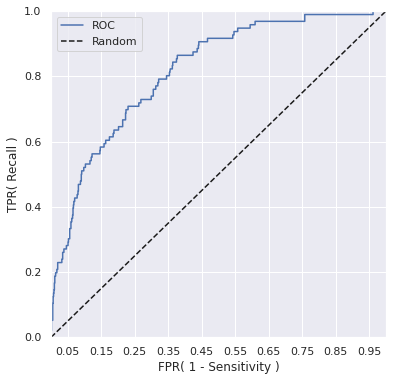

In [29]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    plt.figure(figsize=(6,6)) #그래프 크기 설정

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )


###4.5 Confusion Matrix

In [30]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [31]:
lr_clf = LogisticRegression(max_iter=300)

lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test , pred)

오차 행렬
[[804   5]
 [ 84  12]]
정확도: 0.9017, 정밀도: 0.7059, 재현율: 0.1250


###4.6 Binarizer

여러개의 분류 결정 임곗값을 변경하면서  Binarizer를 이용하여 예측값 변환

In [33]:
pred_proba = lr_clf.predict_proba(X_test)
#해당 클래스로 분류될 확률로 계산되어있음 50%를 threshold 로 잡아놓고 yes/no 나눔
pred  = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array 와 예측 결과값 array 를 concatenate 하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba , pred.reshape(-1,1)],axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])
#첫번째 클래스 값, 두번째 클래스 값
#두 번째 열이 50%가 넘으면 1, 아니면 0


pred_proba()결과 Shape : (905, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.86254638 0.13745362]
 [0.95322235 0.04677765]
 [0.85355318 0.14644682]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.86254638 0.13745362 0.        ]
 [0.95322235 0.04677765 0.        ]
 [0.85355318 0.14644682 0.        ]]


In [34]:
from sklearn.preprocessing import Binarizer

# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장. 
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict)

get_eval_by_threshold(y_test ,pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.4
오차 행렬
[[801   8]
 [ 80  16]]
정확도: 0.9028, 정밀도: 0.6667, 재현율: 0.1667
임곗값: 0.45
오차 행렬
[[802   7]
 [ 83  13]]
정확도: 0.9006, 정밀도: 0.6500, 재현율: 0.1354
임곗값: 0.5
오차 행렬
[[804   5]
 [ 84  12]]
정확도: 0.9017, 정밀도: 0.7059, 재현율: 0.1250
임곗값: 0.55
오차 행렬
[[805   4]
 [ 87   9]]
정확도: 0.8994, 정밀도: 0.6923, 재현율: 0.0938
임곗값: 0.6
오차 행렬
[[805   4]
 [ 90   6]]
정확도: 0.8961, 정밀도: 0.6000, 재현율: 0.0625


precision_recall_curve( ) 를 이용하여 임곗값에 따른 정밀도-재현율 값 추출

In [35]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력 
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1 )
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)
print('반환된 precisions 배열의 Shape:', precisions.shape)
print('반환된 recalls 배열의 Shape:', recalls.shape)

print("thresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5])

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (796,)
반환된 precisions 배열의 Shape: (797,)
반환된 recalls 배열의 Shape: (797,)
thresholds 5 sample: [0.01437282 0.01451748 0.01459179 0.01478067 0.0149773 ]
precisions 5 sample: [0.10983982 0.10882016 0.10894495 0.10907003 0.1091954 ]
recalls 5 sample: [1.         0.98958333 0.98958333 0.98958333 0.98958333]
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150 165 180 195 210 225 240 255
 270 285 300 315 330 345 360 375 390 405 420 435 450 465 480 495 510 525
 540 555 570 585 600 615 630 645 660 675 690 705 720 735 750 765 780 795]
샘플용 10개의 임곗값:  [0.01 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03 0.04 0.04 0.04 0.05 0.05
 0.05 0.06 0.06 0.07 0.07 0.07 0.07 0.08 0.08 0.08 0.08 0.08 0.09 0.09
 0.09 0.1  0.1  0.1  0.11 0.11 0.12 0.12 0.13 0.13 0.14 0.14 0.14 0.15
 0.15 0.16 0.16 0.17 0.18 0.19 0.21 0.22 0.26 0.34 0.53 1.  ]
샘플 임계값별 정밀도:  [0.11  0.111 0.113 0.116 0.118 0.122 0.126 0.129 0.131 0.133 0.135 0.138
 0.141 0.144 0.148 0.152 0.156 0.158 0.161 0.166

임곗값의 변경에 따른 정밀도-재현율 변화 곡선을 그림

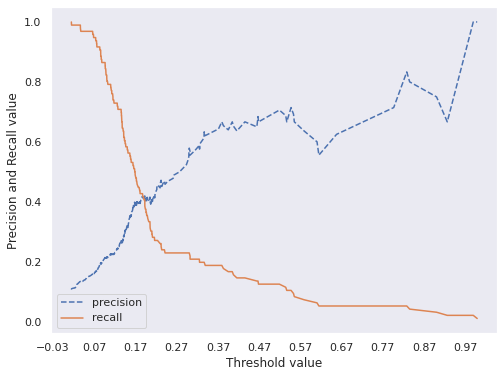

In [36]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )


##5. 의미있는 변수를 선정해서 앞선 항목 재수행

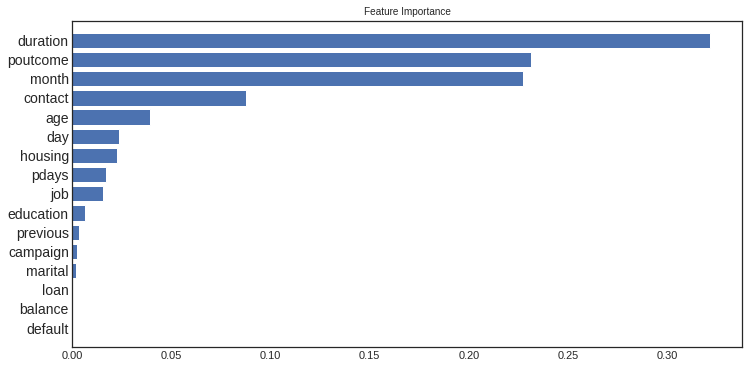

In [ ]:
#변수 중요도 설정하여 데이터 분석을 시행한다.
#의사결정나무분류기로 변수 중요도 파악한다.
plt.style.use('seaborn-white')

clf = DecisionTreeClassifier(class_weight='balanced', min_weight_fraction_leaf = 0.01)

clf.fit(X_train, y_train)
importances = clf.feature_importances_
feature_names = bank_pre.drop('y', axis=1).columns
indices = np.argsort(importances)

def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Feature Importance", fontsize=10)
    plt.barh(range(len(indices)), importances[indices], color='b',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])
    
feature_importance_graph(indices, importances, feature_names)
plt.show()

상위 7개 항목인 duration, poutcome, month, contact, age, day, housing 만을 사용하여 테스트해본다.

###5.1 데이터 전처리

**데이터 전처리 방법은 이전 단계와 동일

In [37]:
#독립변수, 종속 변수 나눠주기
y_bank_df_2 = bank_pre['y']
#위에서 구한 7가지 변수외에 나머지 변수 제외시켜준다.
X_bank_df_2 = bank_pre.drop(['pdays', 'job', 'education', 'previous', 'campaign', 'marital', 'loan', 'balance', 'default', 'y'], axis = 1)


In [38]:
X_bank_df_2 = X_bank_df_2.astype('int')
y_bank_df_2 = y_bank_df_2.astype('int')

In [39]:
#train set : test set = 80 : 20

from sklearn.model_selection import train_test_split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_bank_df_2, y_bank_df_2, \
                                                  test_size=0.2, random_state=11)


In [40]:
X_train_2 = X_train_2.astype('int')
y_train_2 = y_train_2.astype('int')
X_test_2 = X_test_2.astype('int')
y_test_2 = y_test_2.astype('int')

###5.2 데이터 분석

앞선 방법과 동일한 데이터 분석방법 사용한다.

의사결정나무, 랜덤포레스트, 로지스틱 회귀

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 의사결정나무, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf_2 = DecisionTreeClassifier(random_state=11)
rf_clf_2 = RandomForestClassifier(random_state=11)
lr_clf_2 = LogisticRegression(max_iter=300)


# DecisionTreeClassifier 학습/예측/평가
dt_clf_2.fit(X_train_2 , y_train_2)
dt_pred_2 = dt_clf_2.predict(X_test_2)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test_2, dt_pred_2)))

# RandomForestClassifier 학습/예측/평가
rf_clf_2.fit(X_train_2 , y_train_2)
rf_pred_2 = rf_clf_2.predict(X_test_2)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(y_test_2, rf_pred_2)))

# LogisticRegression 학습/예측/평가
lr_clf_2.fit(X_train_2 , y_train_2)
lr_pred_2 = lr_clf_2.predict(X_test_2)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test_2, lr_pred_2)))

DecisionTreeClassifier 정확도: 0.8707
RandomForestClassifier 정확도:0.8840
LogisticRegression 정확도: 0.8983


K-fold

In [49]:
from sklearn.model_selection import KFold
#decision tree에 대해 5-fold
def exec_kfold(clf, folds=5):
    # 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한  리스트 객체 생성.
    kfold = KFold(n_splits=folds)
    scores = []
    
    # KFold 교차 검증 수행. 
    for iter_count , (train_index, test_index) in enumerate(kfold.split(X_bank_df_2)):
        # X_bank_df_2 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train_2, X_test_2 = X_bank_df_2.values[train_index], X_bank_df_2.values[test_index]
        y_train_2, y_test_2 = y_bank_df_2.values[train_index], y_bank_df_2.values[test_index]
        
        
        # Classifier 학습, 예측, 정확도 계산 
        clf.fit(X_train_2, y_train_2) 
        predictions = clf.predict(X_test_2)
        accuracy = accuracy_score(y_test_2, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))     
    
    # 5개 fold에서의 평균 정확도 계산. 
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score)) 
# exec_kfold 호출
exec_kfold(dt_clf_2 , folds=5) 


교차 검증 0 정확도: 0.8862
교차 검증 1 정확도: 0.8872
교차 검증 2 정확도: 0.8827
교차 검증 3 정확도: 0.8894
교차 검증 4 정확도: 0.8805
평균 정확도: 0.8852


In [50]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf_2, X_bank_df_2 , y_bank_df_2 , cv=5, error_score='raise') #클래스가 불균형하게 섞여있을 때 트레인/테스트 분류: 층화

for iter_count,accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))

print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.8818
교차 검증 1 정확도: 0.8894
교차 검증 2 정확도: 0.8827
교차 검증 3 정확도: 0.8861
교차 검증 4 정확도: 0.8805
평균 정확도: 0.8841


-> 전체 변수를 사용했을 때와 다르게, 층화 교차검증을 사용했을 때 평균 정확도가 올라가지 않는다.

GridSearchCV

In [51]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],
             'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]}

grid_dclf_2 = GridSearchCV(dt_clf_2 , param_grid=parameters , scoring='accuracy' , cv=5)
grid_dclf_2.fit(X_train_2 , y_train_2)

print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf_2.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf_2.best_score_))
best_dclf_2 = grid_dclf_2.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
dpredictions_2 = best_dclf_2.predict(X_test_2)
accuracy_2 = accuracy_score(y_test_2 , dpredictions_2)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.8916
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8805


-> 앞선 의사결정나무의 정확도(0.8707)보다 정확도가 상승하였다.

ROC curve

In [52]:
from sklearn.metrics import roc_auc_score

pred_proba_2 = lr_clf_2.predict_proba(X_test_2)[:, 1]
roc_score_2 = roc_auc_score(y_test_2, pred_proba_2)
print('ROC AUC 값: {0:.4f}'.format(roc_score_2))
#roc_auc_score 함수를 이용하여 AUC 값 쉽게 가져올 수 있음

ROC AUC 값: 0.7894


In [ ]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1_2 = lr_clf_2.predict_proba(X_test_2)[:, 1] 

fprs_2 , tprs_2 , thresholds_2 = roc_curve(y_test_2, pred_proba_class1_2)
#roc_curve 함수를 사용해 그래프를 그리는 값 가져옴
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출. 
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index_2 = np.arange(1, thresholds_2.shape[0],5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index_2)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds_2[thr_index_2], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs_2[thr_index_2], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs_2[thr_index_2], 3))

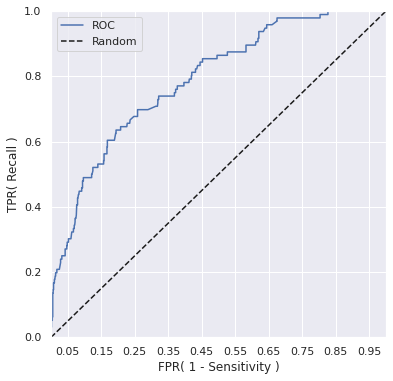

In [55]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    plt.figure(figsize=(6,6))


    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test_2, lr_clf_2.predict_proba(X_test_2)[:, 1] )


Confusion Matrix

In [56]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [57]:
lr_clf_2 = LogisticRegression(max_iter=300)

lr_clf_2.fit(X_train_2 , y_train_2)
pred_2 = lr_clf_2.predict(X_test_2)
get_clf_eval(y_test_2 , pred_2)

오차 행렬
[[805   4]
 [ 88   8]]
정확도: 0.8983, 정밀도: 0.6667, 재현율: 0.0833


Precision/Recall Trade-off

In [58]:
pred_proba_2 = lr_clf_2.predict_proba(X_test_2)
#해당 클래스로 분류될 확률로 계산되어있음 50%를 threshold 로 잡아놓고 yes/no 나눔
pred_2  = lr_clf_2.predict(X_test_2)
print('pred_proba()결과 Shape : {0}'.format(pred_proba_2.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba_2[:3])

# 예측 확률 array 와 예측 결과값 array 를 concatenate 하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result_2 = np.concatenate([pred_proba_2 , pred_2.reshape(-1,1)],axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result_2[:3])
#첫번째 클래스 값, 두번째 클래스 값
#두 번째 열이 50%가 넘으면 1, 아니면 0


pred_proba()결과 Shape : (905, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.86620434 0.13379566]
 [0.91545505 0.08454495]
 [0.86606385 0.13393615]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.86620434 0.13379566 0.        ]
 [0.91545505 0.08454495 0.        ]
 [0.86606385 0.13393615 0.        ]]


Binarizer

In [59]:
pred_proba_2 = lr_clf_2.predict_proba(X_test_2)
#해당 클래스로 분류될 확률로 계산되어있음 50%를 threshold 로 잡아놓고 yes/no 나눔
pred_2  = lr_clf_2.predict(X_test_2)
print('pred_proba()결과 Shape : {0}'.format(pred_proba_2.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba_2[:3])

# 예측 확률 array 와 예측 결과값 array 를 concatenate 하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result_2 = np.concatenate([pred_proba_2 , pred_2.reshape(-1,1)],axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result_2[:3])
#첫번째 클래스 값, 두번째 클래스 값
#두 번째 열이 50%가 넘으면 1, 아니면 0


pred_proba()결과 Shape : (905, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.86620434 0.13379566]
 [0.91545505 0.08454495]
 [0.86606385 0.13393615]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.86620434 0.13379566 0.        ]
 [0.91545505 0.08454495 0.        ]
 [0.86606385 0.13393615 0.        ]]


In [60]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장. 
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict)

get_eval_by_threshold(y_test_2 ,pred_proba_2[:,1].reshape(-1,1), thresholds )

임곗값: 0.4
오차 행렬
[[804   5]
 [ 83  13]]
정확도: 0.9028, 정밀도: 0.7222, 재현율: 0.1354
임곗값: 0.45
오차 행렬
[[805   4]
 [ 84  12]]
정확도: 0.9028, 정밀도: 0.7500, 재현율: 0.1250
임곗값: 0.5
오차 행렬
[[805   4]
 [ 88   8]]
정확도: 0.8983, 정밀도: 0.6667, 재현율: 0.0833
임곗값: 0.55
오차 행렬
[[806   3]
 [ 90   6]]
정확도: 0.8972, 정밀도: 0.6667, 재현율: 0.0625
임곗값: 0.6
오차 행렬
[[806   3]
 [ 90   6]]
정확도: 0.8972, 정밀도: 0.6667, 재현율: 0.0625


precision_recall_curve( ) 를 이용하여 임곗값에 따른 정밀도-재현율 값 추출

In [61]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1_2 = lr_clf_2.predict_proba(X_test_2)[:, 1] 

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력 
precisions, recalls, thresholds = precision_recall_curve(y_test_2, pred_proba_class1_2)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)
print('반환된 precisions 배열의 Shape:', precisions.shape)
print('반환된 recalls 배열의 Shape:', recalls.shape)

print("thresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5])

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (317,)
반환된 precisions 배열의 Shape: (318,)
반환된 recalls 배열의 Shape: (318,)
thresholds 5 sample: [0.027487   0.02759064 0.02867271 0.02964936 0.03357369]
precisions 5 sample: [0.1254902  0.12434555 0.12683578 0.12734584 0.12751678]
recalls 5 sample: [1.         0.98958333 0.98958333 0.98958333 0.98958333]
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150 165 180 195 210 225 240 255
 270 285 300 315]
샘플용 10개의 임곗값:  [0.03 0.04 0.05 0.06 0.07 0.07 0.08 0.08 0.1  0.11 0.12 0.12 0.13 0.14
 0.15 0.16 0.18 0.2  0.23 0.29 0.43 0.98]
샘플 임계값별 정밀도:  [0.125 0.129 0.139 0.147 0.152 0.153 0.164 0.182 0.185 0.188 0.192 0.236
 0.267 0.286 0.327 0.387 0.371 0.408 0.444 0.588 0.765 1.   ]
샘플 임계값별 재현율:  [1.    0.979 0.979 0.958 0.938 0.875 0.865 0.844 0.802 0.771 0.74  0.698
 0.646 0.562 0.5   0.448 0.344 0.302 0.25  0.208 0.135 0.021]


임곗값의 변경에 따른 정밀도-재현율 변화 곡선을 그림

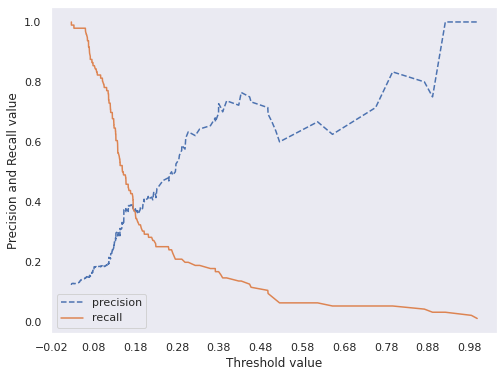

In [62]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test_2, lr_clf_2.predict_proba(X_test_2)[:, 1] )


#6.결론

1. 의사결정나무분류기를 사용하여 변수의 중요도를 계산하여 변수를 선정하여 데이터 분석을 한 결과 전체 변수를 사용하여 분석을 진행하였을 때 보다 의사결정나무와 관련된 결과에서만 정확도가 상승하였다.

2. 의사결정나무, 의사결정나무에 대한 k-fold, 층화교차검증에서 정확도가 상승하였다.

3. 전체 방법 중 로지스틱 회귀를 사용한 분석에서 가장 높은 정확도를 보여주었다.

